#### Assignment3 - Question1 

Guangyuan Chen

##### firstly, initialize the environment and read the dask data

In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client

/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [2]:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "4GiB"
                      )
cluster.scale(8)
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://172.31.30.1:8786
distributed.scheduler - INFO -   dashboard at:                    :37965
22/06/03 19:33:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/03 19:33:32 INFO client.RMProxy: Connecting to ResourceManager at ip-172-31-30-1.ec2.internal/172.31.30.1:8032
22/06/03 19:33:32 INFO client.AHSProxy: Connecting to Application History server at ip-172-31-30-1.ec2.internal/172.31.30.1:10200
22/06/03 19:33:33 INFO skein.Driver: Driver started, listening on 41605
22/06/03 19:33:33 INFO conf.Configuration: resource-types.xml not found
22/06/03 19:33:33 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
22/06/03 19:33:33 INFO skein.Driver: Uploading application resources to hdfs://ip-172-31-30-1.ec2.internal:8020/user/hadoop/.skein/application_1654282829872_0001
22/06/03 19:33:35 INF

In [3]:
client

Connection method: Cluster object,Cluster type: YarnCluster
Dashboard: /proxy/37965/status,


distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.22.246:34987', name: dask.worker_3, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.22.246:34987
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.22.246:37905', name: dask.worker_2, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.22.246:37905
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.29.72:40757', name: dask.worker_1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.29.72:40757
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.29.72:42115', name: dask.worker_4, memory: 0, processing: 0>
distributed.schedu

##### 1. Read the data from dask

In [49]:
import dask.dataframe as dd

lyric_data = dd.read_csv('s3://finalprojectlyrics/top_100_lyrics.csv').drop('Unnamed: 0', axis=1)
singer_data = dd.read_csv('s3://finalprojectlyrics/singer_data.csv')

lyric_data.columns = ['year', 'singer', 'name', 'lyrics']
lyric_data['decade'] = lyric_data['year'].astype(str).str[:3] + '0'

singer_data = singer_data[['artist_mb', 'country_mb', 'tags_mb']]
singer_data.columns = ['singer', 'country', 'tags']
singer_data = singer_data.drop_duplicates(subset=['singer'])

In [50]:
# convert Uppercase into lowercase
lyric_data['singer'] = lyric_data['singer'].apply(lambda a: a.lower())
singer_data['singer'] = singer_data['singer'].astype('str').apply(lambda a: a.lower())

/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/core.py:3608: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('singer', 'object'))

  warnings.warn(meta_warning(meta))
/home/hadoop/miniconda/lib/python3.8/site-packages/dask/dataframe/core.py:3608: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('singer', 'object'

In [51]:
# combine these two datasets
combined_data = dd.merge(lyric_data, singer_data, on='singer', how='left')
combined_data.head(5)

,year,singer,name,lyrics,decade,country,tags
0,1958,boots brown and his blockbusters,Cerveza,cerveza lyricsinstrumental instrumentalembed,1950,NaN,NaN
1,1958,doris day,Tunnel Of Love,tunnel love lyricsgetting crazy waltzers life ...,1950,United States,pop; american; big band; film soundtrack; easy...
2,1958,billy & lillie,Lucky Ladybug,lucky ladybug lyricslucky ladybug lucky ladybu...,1950,United States,NaN
3,1958,frank sinatra,Mr. Success,mr success lyricswhen walk jam knows head ches...,1950,United States,pop; jazz; vocal; christmas; swing; big band; ...
4,1958,the rinky-dinks,Early In The Morning,early morning lyricswell youre gonna miss earl...,1950,NaN,NaN


##### 2. Superstars in each decade

In [53]:
superstar_each_decade = lyric_data[lyric_data.singer != 'glee cast'].groupby(['decade', 'singer'])['name'].count().reset_index().reset_index(drop=True).groupby('decade').apply(lambda a: a[a['name'] >= a['name'].max()]).reset_index(drop=True)
superstar_each_decade.compute()

/tmp/ipykernel_14636/3930122925.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  superstar_each_decade = lyric_data[lyric_data.singer != 'glee cast'].groupby(['decade', 'singer'])['name'].count().reset_index().reset_index(drop=True).groupby('decade').apply(lambda a: a[a['name'] >= a['name'].max()]).reset_index(drop=True)


,decade,singer,name
0,1950,fats domino,5
1,1960,connie francis,9
2,1960,ray charles,9
3,1970,commodores,7
4,1980,dan fogelberg,8
5,1980,lionel richie,8
6,1990,elton john,7
7,1990,sarah mclachlan,7
8,2000,taylor swift,12
9,2010,taylor swift,20


##### 3. total singers over decades (competition)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


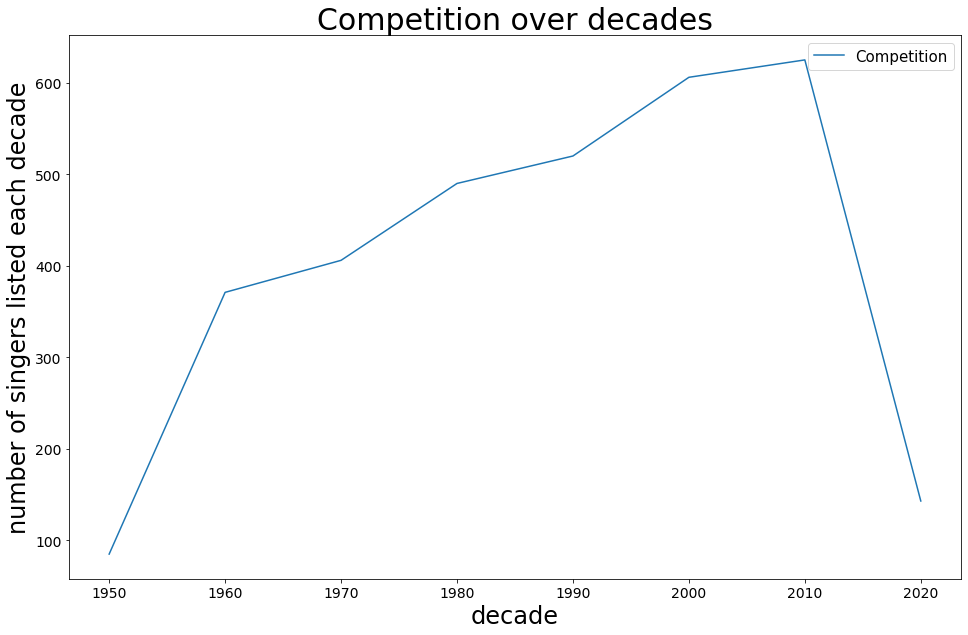

In [56]:
import warnings
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']

total_singer_each_decade = lyric_data.groupby('decade').apply(lambda a: len(a['singer'].unique())).to_frame("Competition").compute()
ax = total_singer_each_decade.plot(figsize=(16, 10))
ax.set_ylabel('number of singers listed each decade', size=24)
ax.set_title("Competition over decades", size=30)
ax.set_xlabel('decade', size=24)
plt.legend(fontsize=15)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig("competition.png")

##### singers' country distribution over decades

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


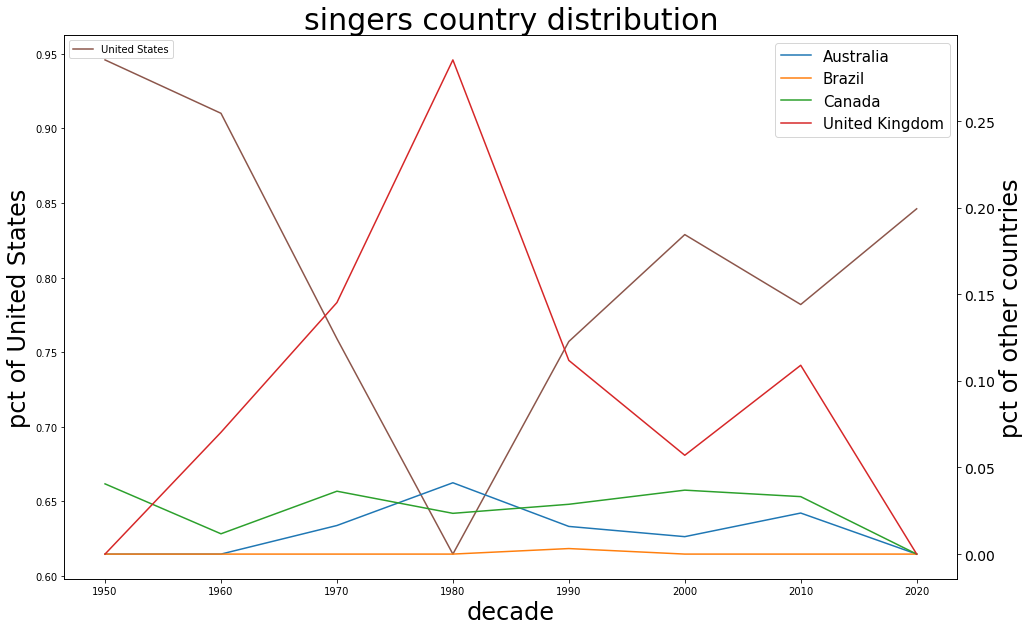

In [57]:
country_data = combined_data[combined_data.country.notnull()].drop_duplicates('singer').compute()
country_data['country_freq'] = country_data.groupby(['decade', 'country'])['name'].transform(lambda a: a.count())
country_data2 = country_data.groupby(['decade', 'country'])['country_freq'].mean().reset_index()
country_data2['country_pct'] = country_data2.groupby('decade')['country_freq'].transform(sum)
country_data2['country_pct'] = country_data2['country_freq'] / country_data2['country_pct']
country_data3 = country_data2.set_index(['decade', 'country'])['country_pct'].unstack()[['Australia', 'Brazil', 'Canada', 'United Kingdom', 'United States']].fillna(0)

ax = country_data3[['United States']].plot(figsize=(16, 10),color=cmap(5))
ax2 = ax.twinx()
country_data3.drop('United States', axis=1).plot(ax=ax2)
ax.legend(fontsize=15)
ax2.legend(fontsize=15)

ax.legend(loc='upper left')

ax.set_xlabel("decade", size=24)
ax.set_ylabel("pct of United States", size=24)
ax2.set_ylabel("pct of other countries", size=24)
plt.title("singers country distribution", size=30)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig("country.png")

##### 5. music genres distribution

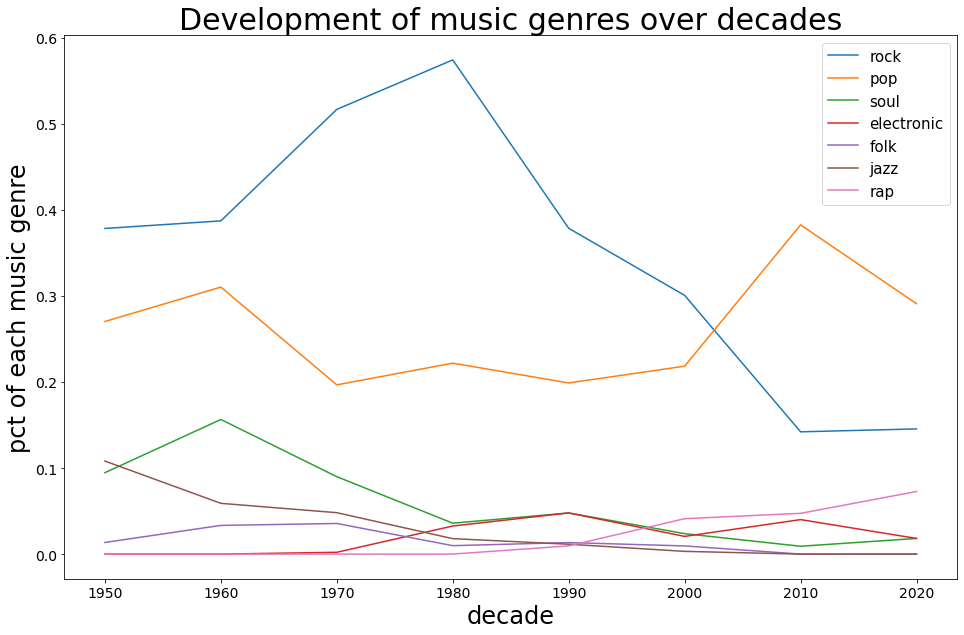

In [59]:
style_data = combined_data[combined_data.tags.notnull()]
style_data['style'] = style_data['tags'].apply(lambda a: a.split(';')[0])
style_data['style_freq'] = style_data.groupby(['decade', 'style'])['name'].transform(lambda a: a.count())
style_data2 = style_data.groupby(['decade', 'style'])['style_freq'].mean().reset_index().compute()
style_data2['style_pct'] = style_data2.groupby('decade')['style_freq'].transform(sum)
style_data2['style_pct'] = style_data2['style_freq'] / style_data2['style_pct']

style_data2.loc[style_data2['style'].apply(lambda a: 'rock' in a), 'rock'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'pop' in a), 'pop'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'soul' in a), 'soul'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'electronic' in a), 'electronic'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'folk' in a), 'folk'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'jazz' in a), 'jazz'] = style_data2['style_pct']
style_data2.loc[style_data2['style'].apply(lambda a: 'rap' in a), 'rap'] = style_data2['style_pct']
style_data3 = style_data2.fillna(0.0).groupby('decade')[['rock', 'pop', 'soul', 'electronic', 'folk', 'jazz', 'rap']].sum()
ax = style_data3.plot(figsize=(16, 10))

ax.set_ylabel('pct of each music genre', size=24)
ax.set_xlabel('decade', size=24)
ax.set_title("Development of music genres over decades", size=30)
plt.legend(fontsize=15)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig("genre.png")
